# part 2

### Loading the model and analysis from part 1

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv('./data/laptopData.csv')

# Rename the column 'Unnamed: 0' to 'ID'
data.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Define the adjusted exchange rate based on a specific example
price_in_pkr_example = 47895.5232  # Example price in PKR
target_price_usd = 1000  # Desired average price in USD
adjusted_exchange_rate = price_in_pkr_example / target_price_usd

# Convert the 'Price' column to USD and replace the original column
data['Price'] = data['Price'] / adjusted_exchange_rate

# Create a copy of the original DataFrame
copy_data = data.copy()

# Remove rows with NaN values in the 'Price' column
copy_data = copy_data[~copy_data['Price'].isna()]

# Display rows number
print("Number of rows in the original DataFrame:", copy_data.shape[0])

#display data types of each column
print("Data types:" )
print(copy_data.dtypes)

# Display the first few rows of the modified DataFrame
copy_data.head()

Number of rows in the original DataFrame: 1273
Data types:
ID                  float64
Company              object
TypeName             object
Inches               object
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object


,ID,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1490.299686
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,1000.000000
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,639.642245
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2822.713418
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,2006.363050


## preproccing

In [2]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical features to numeric using Label Encoding
categorical_features = ['Company', 'TypeName', 'OpSys' , 'Gpu', 'Memory', 'Ram', 'Cpu', 'ScreenResolution', 'Inches', 'Weight']
encoder = LabelEncoder()
model_data = copy_data.copy()

for feature in categorical_features:
    model_data[feature] = encoder.fit_transform(model_data[feature])

# Remove the 'ID' column
model_data = model_data.drop(columns=['ID'])

# Select all numeric features (after encoding)
numeric_features = model_data.select_dtypes(include=[np.number])
print("Encoded columns done.")

Encoded columns done.


## Basic Model Pipeline 

In [3]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Feature selection and target variable
X = model_data.drop(columns=['Price'])
y = model_data['Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)
    
# Make predictions
y_pred = model.predict(X_test)

print("Model training complete.")

Model training complete.


## Results of the basic pipeline

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print(f"Model Performance Metrics:")
print(f"RMSE: {rmse:.2f}k")
print(f"MAE: {mae:.2f}k")
print(f"R2 Score: {r2:.3f}")


Model Performance Metrics:
RMSE: 313.30k
MAE: 193.69k
R2 Score: 0.845


# Error Analysis
After running the basic model, we will analyze its errors to identify areas for improvement.

### A. Predicted vs Actual Price


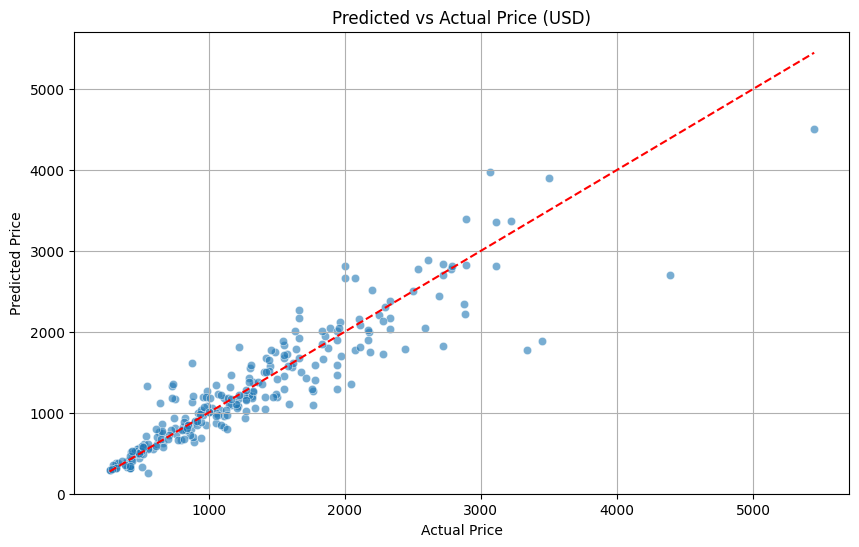

In [5]:
# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Price (USD)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()

#### Insights
- **Strong Correlation**:
    The points closely follow the red diagonal line, indicating that the model's predictions are strongly correlated with the actual prices. This suggests the model is performing well.
- **Outliers**:
    A few points significantly deviate from the red line. These represent outliers where the model struggles to predict accurately, potentially due to unusual or extreme values in the data.
- **Key Actionable Insights**:
    - The model is reliable for the majority of the dataset but struggles with extreme cases (outliers). Investigating these outliers could provide insights into model improvement, such as refining feature engineering or handling rare cases differently.
    - The consistent clustering around the diagonal shows that the feature selection and preprocessing were effective in creating an accurate model.


### B. Error Distribution

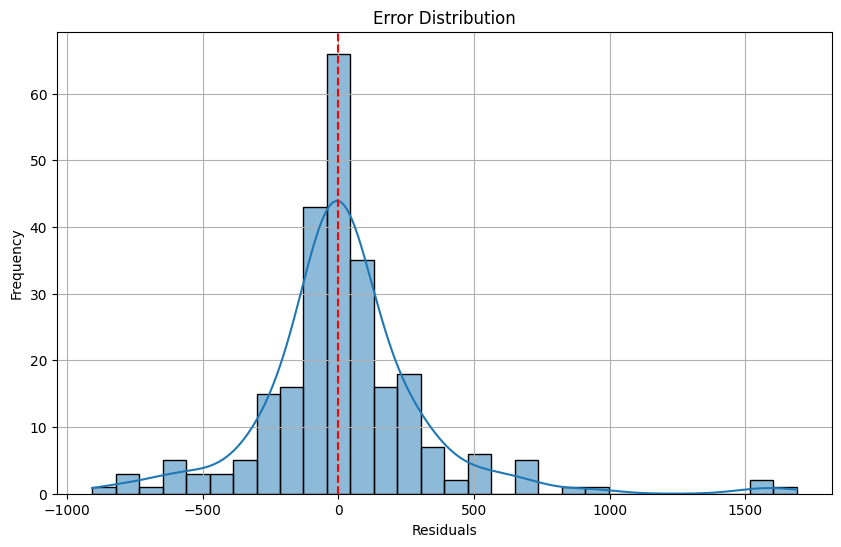

In [6]:
# Calculate residuals
residuals = y_test - y_pred

# Plot Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual (Perfect Prediction)')
plt.title("Error Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


#### Insights
- **Concentration of Residuals**:
    The majority of residuals are tightly clustered around zero, reinforcing the model's general accuracy across most predictions. This suggests a strong alignment between actual and predicted prices for the bulk of the data.

- **Distribution Patterns**:
    The presence of a relatively smooth curve suggests that the errors follow an approximately normal distribution. This supports the assumption that the model handles errors systematically rather than erratically, which is favorable for further tuning and improvement.

- **Actionable Insight**:
    The slight skewness and presence of outliers on the positive side suggest a need to explore higher-priced laptops in more detail. For instance, feature engineering (like better handling of brand-specific effects or rare configurations) may reduce these overestimations.


### C. Features Importance

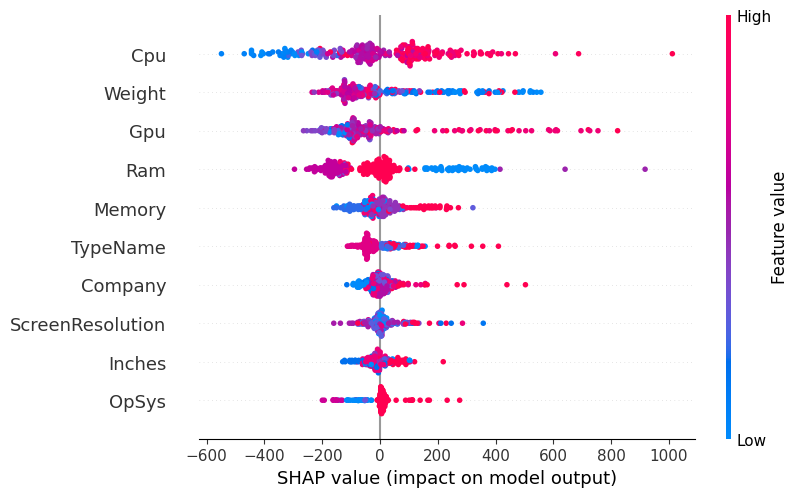

In [7]:
import shap

# Calculate SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot SHAP beeswarm plot
shap.plots.beeswarm(shap_values)

#### Insights
- **Feature Importance and Contribution**:
   - **Cpu, Weight, and Gpu** have significant SHAP values, indicating they are critical for predicting price.
   - Features like **OpSys** and **Inches** have relatively small SHAP values, meaning they have a limited impact on price prediction.

- **Most Influential Feature**:
    Among all features, **Cpu** stands out as the most consistently impactful on price prediction. Higher CPU performance (e.g., speed, generation) strongly correlates with higher prices, reflecting the importance of computational power in determining the value of laptops.

- **Outliers and Variability**:
   - Some features, such as **Gpu** and **Weight**, have wide spreads of SHAP values, indicating variability in their influence across the dataset.
   - The presence of outliers (dots far from the cluster) suggests specific cases where a feature has an unusually high or low impact.

- **Actionable Insight**:
   - Features with high SHAP value variability, like **Gpu** and **Weight**, might require further feature engineering or detailed analysis to capture their nuanced effects better.
   - **OpSys** and **Inches** may have less relevance for price prediction and could potentially be deprioritized or re-examined.

### D. Overestimations and Underestimations by Price

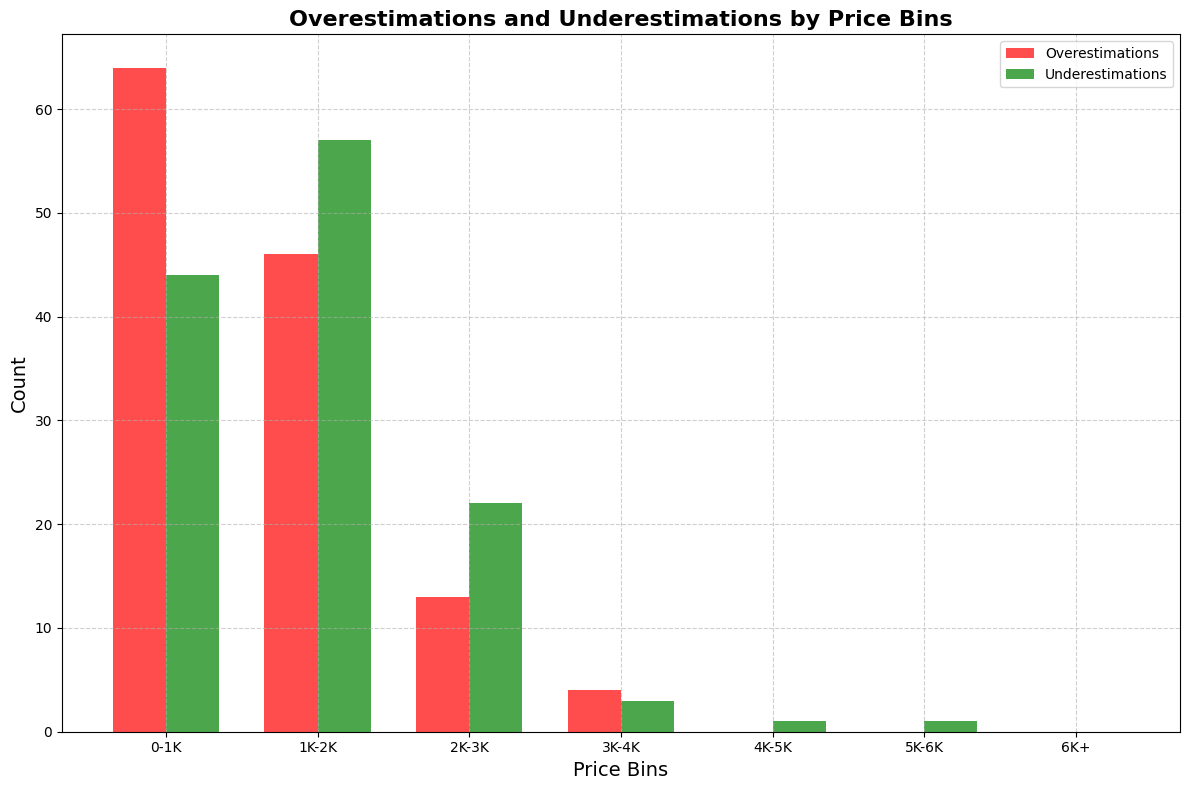

In [8]:

# Define bins for price ranges
price_bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
price_labels = ['0-1K', '1K-2K', '2K-3K', '3K-4K', '4K-5K', '5K-6K', '6K+']
y_test_binned = pd.cut(y_test, bins=price_bins, labels=price_labels)

# Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred,
    'Residual': residuals,
    'Price Range': y_test_binned
})

# Calculate overestimations and underestimations by price range
over_under_estimations = analysis_df.groupby('Price Range').apply(
    lambda group: pd.Series({
        'Overestimations': (group['Residual'] < 0).sum(),
        'Underestimations': (group['Residual'] > 0).sum()
    })
).reset_index()

# Plot overestimations and underestimations by price range
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(over_under_estimations))

plt.bar(index, over_under_estimations['Overestimations'], bar_width, label='Overestimations', color='red', alpha=0.7)
plt.bar(index + bar_width, over_under_estimations['Underestimations'], bar_width, label='Underestimations', color='green', alpha=0.7)

plt.ylabel('Count', fontsize=14)
plt.xlabel('Price Bins', fontsize=14)
plt.title('Overestimations and Underestimations by Price Bins', fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, over_under_estimations['Price Range'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Insights
- **Higher Errors in Lower Price Ranges**:
    The **0-1K** and **1K-2K** price bins exhibit a higher number of both overestimations (red bars) and underestimations (green bars). This indicates that the model struggles to predict accurately in the lower price range, possibly due to higher variability or the influence of features not fully captured by the model.

- **Imbalance Between Overestimations and Underestimations**:
   - In the **0-1K** range, overestimations (red) are more frequent than underestimations (green), indicating a bias where the model predicts higher prices than the actual ones for lower-cost laptops.
   - Conversely, in the **2K-3K** range, underestimations are more frequent, implying that the model undervalues some laptops in this range.

- **Actionable Insights**:
   - Focus on improving model performance for the **0-2K** range by examining feature contributions and ensuring that key predictors (e.g., RAM, CPU) are appropriately weighted for these lower-priced laptops.
   - Investigate cases of frequent underestimations in the **2K-3K** range to refine the model for this category.
   - Collect more data or adjust the model for high-priced laptops (**4K+**) to increase reliability in this segment.

### After loading the model and analysis from part 1 let's start part 2
<hr>

# Error Analysis Conclusions & work plan

### **Error Analysis Conclusions**

**1. Predicted vs. Actual Price**
- **Observation:**  
  The scatterplot demonstrates a strong alignment between predicted and actual prices, particularly in the mid-range price points. Data points are clustered closely along the red diagonal line, indicating accurate predictions in most cases. However, deviations occur, particularly in the low and high-price ranges, where the model's predictions diverge significantly from the actual values.  
- **Error Identified:**  
  Outliers reveal the model's struggles in generalizing predictions for specific price points, particularly for low-cost and luxury laptops.  
- **Potential Causes:**  
  - **Low Price Range:**<br>
  Overestimations in this segment suggest the model overweights features that contribute less to pricing for entry-level laptops, potentially due to insufficient granularity in these features.  
  - **High Price Range:**<br>
  Underestimations occur for high-end laptops, where unique configurations or premium brand effects are inadequately captured.
  - **Presence of Outliers:**<br>
  Outliers in the dataset disproportionately affect the training process, skewing predictions in both low and high-price ranges.

**2. Error Distribution**
- **Observation:**  
  Residuals are tightly centered around zero, indicating reliable performance. However, the tails of the distribution show notable overestimations and underestimations, representing edge cases the model struggles to predict accurately.  
- **Error Identified:**  
  These extreme residuals highlight limitations in the model's ability to address outliers or cases with unusual combinations of features.  
- **Potential Causes:**  
  - **Feature Representation Gaps:**<br>
  Some critical price-driving factors, such as brand reputation or niche hardware configurations, may not be fully captured.  
  - **Complex Interactions:**<br>
  The model may not fully grasp the nuanced, non-linear relationships between key features, resulting in prediction errors for complex configurations.
  - **Inefficient Features:**<br>
  Redundant features may have diluted the influence of meaningful predictors, reducing the model’s ability to generalize effectively.

**3. SHAP Value Analysis**
- **Observation:**  
  Features like **CPU**, **GPU**, and **RAM** exhibit substantial predictive power, as evidenced by their high SHAP values. However, their contributions vary significantly, implying the presence of complex interactions or dependencies. Conversely, features like **Operating System** and **Screen Resolution** contribute minimally, suggesting a secondary role in price prediction.  
- **Error Identified:**  
  Variability in SHAP values for critical features reflects the model's partial understanding of their relationships, while minimal impact from lower-priority features points to their limited relevance.  
- **Potential Causes:**  
  - **High Variability Features:**<br>
  Features like **GPU** and **RAM** interact heavily with other features, creating dependencies that the model struggles to capture fully.  
  - **Low Impact Features:**<br>
  Features like **Operating System** might not capture meaningful variation in price due to insufficient variability in the dataset or the feature's secondary role in pricing.
  - **Missing Values:**<br>
  Improper handling of missing values in key features could have skewed the importance assigned to certain predictors.

**4. Overestimations and Underestimations by Price Range**
- **Observation:**  
  - **Overestimations:**<br>
  Occur predominantly in the 0-1K USD range, where cheaper laptops are often predicted to cost more than their actual price.  
  - **Underestimations:**<br>
  Common in the 1K-3K USD range, where mid-tier laptops are undervalued compared to their actual price.  
- **Error Identified:**  
  - Overestimations in low-cost laptops suggest the model struggles to capture nuanced differences in entry-level laptops.  
  - Underestimations in mid-tier laptops indicate possible undervaluation of certain feature interactions or lack of sufficient feature representation.  
- **Potential Causes:**  
  - **Low-Price Laptops:**<br>
  Overestimations might result from over-reliance on generic patterns in the data, leading to inflated predictions.  
  - **Mid-Tier Laptops:**<br>
  Underestimations likely stem from feature interactions not being fully leveraged to highlight mid-tier strengths, such as balanced performance and affordability.
  - **Presence of Outliers:**<br>
  Outliers within specific price ranges, particularly at the extremes, may disproportionately affect the model’s ability to generalize.


### **Work Plan for Error Reduction**

**1. Handle inefficient Features**
   - **Proposed Solution:**<br>
   Perform feature selection and engineering to retain only impactful predictors while eliminating redundant or irrelevant ones.  
   - **Why:**<br>
   Removing inefficient features reduces dataset noise, enhances the model's focus on meaningful variables, and minimizes overfitting by decreasing dimensionality. This leads to a more robust and interpretable model.

**2. Capturing Complex Relationships**  
   - **Proposed Solution:**<br>
   Develop interaction features that reveal complex and nonlinear relationships between variables.  
   - **Why:**<br>
   Sophisticated feature engineering enables the model to understand better intricate dependencies and patterns in the data, enhancing its predictive accuracy and ability to generalize across diverse scenarios that couldn't be revealed before.

**3. Handle missing Values**
   - **Proposed Solution:**<br>
   Apply appropriate imputation techniques, such as median or most frequent imputation, while investigating underlying patterns in the missing data.  
   - **Why:**<br>
   Proper handling of missing values prevents biases introduced by incomplete data, ensures data integrity, and improves the model’s capacity to generalize across unseen data.

**4. Hyperparameter Optimization**  
   - **Proposed Solution:**<br>
   Perform systematic tuning of XGBoost parameters, such as `learning_rate`, `max_depth`, and `n_estimators`, using approaches like `GridSearchCV`, `RandomizedSearchCV`, or Bayesian optimization.  
   - **Why:**<br>
   Optimizing hyperparameters ensures the model is balanced between underfitting and overfitting. This process fine-tunes the model to the dataset's structure, improving both accuracy and resilience to noise and variability.


By systematically addressing these areas, the model can achieve enhanced accuracy, generalization, and resilience to noise. This comprehensive approach ensures the dataset's structure is leveraged effectively while mitigating sources of bias and inefficiency.


# Improving Model Performance


## preproccing

In [9]:
# Convert categorical features to numeric using Label Encoding
categorical_features = ['Company', 'TypeName', 'OpSys' , 'Gpu', 'Memory', 'Ram', 'Cpu', 'ScreenResolution', 'Inches', 'Weight']
encoder = LabelEncoder()

model_data = copy_data.copy()

# Remove the 'ID' column
model_data = model_data.drop(columns=['ID'])

for feature in categorical_features:
    model_data[feature] = encoder.fit_transform(model_data[feature])


### Function to train the Model.

**What is `GridSearchCV`?**  
`GridSearchCV` is a technique used to find the optimal combination of hyperparameters by systematically testing all possible combinations of the values in `param_grid`. It evaluates each combination of hyperparameters using cross-validation (`cv`), ensuring that the model's performance is tested on multiple data splits.  

**Why GridSearchCV may improves the Baseline Model:**  
The baseline model used default hyperparameters, which may not be optimal for the specific dataset. By tuning these parameters, GridSearchCV helps:  
- **Improve Performance**:<br>
Finds the hyperparameters that minimize the error (e.g., negative mean squared error in our case).  
- **Reduce Overfitting/Underfitting**:<br>
Balances the model's complexity to generalize well across different datasets.  
- **Increase Robustness**:<br>
Ensures the model performs consistently across various cross-validation folds.  

**Why Use This Specific Implementation?**  
```
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    scoring='r2', 
    cv=3, 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
```
- **`estimator=xgb_model`**:<br>
Specifies the XGBoost model as the base estimator as in part 1.
- **`param_grid=param_grid`**:<br>
Defines the hyperparameter search space by specifying the possible values for each parameter that will be tested during the grid search. This approach allows for a systematic exploration of multiple combinations of hyperparameters, helping identify the optimal configuration for the model.
- **`scoring='r2'`**:<br>
Chosen as the evaluation metric because it quantifies how well the model explains the variability of the target variable (price).
- **`cv=3`**:<br>
Performs 3-fold cross-validation, dividing the training data into three splits. This ensures that each split is used for both training and validation, reducing the risk of overfitting and ensuring a robust evaluation of the hyperparameters.
- **`n_jobs=-1`**:<br>
Leverages all available CPU cores to parallelize the search process, significantly reducing computation time, especially when the parameter grid is large.  

After the search, the best combination of hyperparameters is stored in `best_model`. This ensures the final model is optimized for performance on the given dataset.



In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV

def improve_model(param_grid, X_train, y_train):
    
    # Initialize the XGBoost model
    xgb_model = xgb.XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    print("New model training complete!")

    return best_model

### Function to Evaluate the model

**Why Evaluate the Model with These Metrics?**

The chosen evaluation metrics – RMSE, MAE, R², and Adjusted R² – are widely used in regression problems because they offer complementary perspectives on the model's performance. Combining them, we understand how well the model predicts and generalizes the target variable to unseen data.


**Explanation of Each Metric**

- **Mean Squared Error (MSE)**
    - **What it Represents:**  
    MSE calculates the average of the squared differences between predicted and actual values. The squaring penalizes larger errors more heavily, making it sensitive to outliers.
    - **Why It's Important:**  
    MSE helps identify whether the model is making large prediction errors and evaluates the overall variance in the predictions. It’s a good metric for detecting how far off the model is, on average.

- **Root Mean Squared Error (RMSE)**
    - **What it Represents:**  
    RMSE is the square root of MSE and measures the average magnitude of errors in the same units as the target variable.
    - **Why It's Important:**  
    RMSE provides an interpretable error metric, as it is directly comparable to the scale of the target variable. For example, if the target variable is laptop prices in USD, RMSE tells us how far on average, the predictions are from the actual prices in USD.

- **Mean Absolute Error (MAE)**
    - **What it Represents:**  
    MAE calculates the average of the absolute differences between predicted and actual values. Unlike MSE, it treats all errors equally without penalizing larger errors more heavily.
    - **Why It's Important:**  
    MAE is robust to outliers and provides a simple measure of the model's average prediction error. It offers an intuitive understanding of the typical magnitude of error, which is important for practical decision-making.

- **R² (Coefficient of Determination)**
    - **What it Represents:**  
    R² measures the proportion of variance in the target variable that is explained by the model. It ranges from 0 to 1, where 1 indicates that the model explains all the variability in the data.
    - **Why It's Important:**  
    R² gives a general sense of the model’s explanatory power. A high R² suggests that the model captures the underlying patterns in the data effectively.

- **Adjusted R²**
    - **What it Represents:**  
    Adjusted R² modifies the R² score by accounting for the number of features (predictors) in the model. It penalizes R² for adding irrelevant features and prevents overestimation of the model's explanatory power when additional features are included.
    - **Why It's Important:**  
    Adjusted R² is especially useful when evaluating models with different numbers of features. It ensures that improvements in R² are not merely due to adding more features but reflect genuine predictive improvements.



In [11]:
def adjusted_r2(y_true, y_pred, n, p):
  r2 = r2_score(y_true, y_pred)
  adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
  return adjusted_r2

def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate adjusted R2
    # Sample number in the test
    n = X_test.shape[0]

    # features number in the test
    p = X_test.shape[1]
    adjusted_r2_value = adjusted_r2(y_test, y_pred, n, p)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return y_pred, rmse, mae, r2, adjusted_r2_value

### Step 1: Hyper tunning and GridSearch
**What is param_grid?**<br>
param_grid is a dictionary that defines the hyperparameters and their possible values that we want to test and optimize in our model. Each key in param_grid corresponds to a specific hyperparameter of the model, and its associated list contains the range of values we want to try.

**In my case i used:**
- **n_estimators** : The number of trees in the ensemble. Increasing this can improve the model's ability to capture patterns, but it also increases training time.
- **max_depth**: The maximum depth of a tree. Deeper trees capture more complex patterns but may risk overfitting.
- **learning_rate**: Controls how much the model adjusts its weights after each iteration. Lower values often result in better generalization but require more iterations.
- **subsample**: Fraction of samples used for fitting each tree. This helps prevent overfitting by introducing randomness.
- **colsample_bytree**: Fraction of features used when building each tree. This encourages diversity among trees and reduces overfitting.


In [12]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7 ,0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("Hyperparameter tuning grid defined successfully!")

Hyperparameter tuning grid defined successfully!


**Why Did I Choose These Hyperparameters and Values?**  
The selected hyperparameters and their ranges were chosen based on the following reasoning:  
- **`n_estimators`:** Tested a range of tree counts (100, 200, 300) to balance between capturing patterns and keeping training time reasonable.  
- **`max_depth`:** Limited to shallow (3), medium (5), and deeper (7) trees to evaluate how model complexity affects performance.  
- **`learning_rate`:** Chose values (0.01, 0.1, 0.2) to explore the trade-off between faster convergence and better generalization.  
- **`subsample`:** Included (0.7, 0.8, 1.0) to experiment with varying levels of data subsampling for regularization.  
- **`colsample_bytree`:** Tested (0.8, 1.0) to explore the impact of using all features versus a subset of features for each tree.  

These values were based on prior knowledge of the XGBoost model, literature recommendations, and experimentation to ensure a comprehensive search space without excessive computational overhead.

### Step 1 Results

In [13]:
# Feature selection and target variable
X = model_data.drop(columns=['Price'])
y = model_data['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = improve_model(param_grid, X_train, y_train)

step1_y_pred_improve, step1_rmse_improve, step1_mae_improve, step1_r2_improve, step1_adjusted_r2_value = evaluate_model(best_model, X_test, y_test)

# Baseline model metrics
baseline_rmse = 313.30
baseline_mae = 193.69
baseline_r2 = 0.845

print("\nNew Model Performance Metrics:")
print(f"Baseline RMSE: {baseline_rmse:.2f} -> Improved Model RMSE: {step1_rmse_improve:.2f}\n")
print(f"Baseline MAE: {baseline_mae:.2f} -> Improved Model MAE: {step1_mae_improve:.2f}\n")
print(f"Baseline R2 Score: {baseline_r2:.3f} -> Improved Model R2 Score: {step1_r2_improve:.3f}\n")


New model training complete!

New Model Performance Metrics:
Baseline RMSE: 313.30 -> Improved Model RMSE: 300.17

Baseline MAE: 193.69 -> Improved Model MAE: 198.60

Baseline R2 Score: 0.845 -> Improved Model R2 Score: 0.858



#### **Identifying and Addressing Weaknesses**

To enhance the model’s performance, I implemented systematically **hyperparameter tuning** using a predefined grid (`param_grid`) to explore combinations of key parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `colsample_bytree`. By utilizing `GridSearchCV`, I ensured a comprehensive search across the parameter space, optimizing the model for the dataset.

**This process targeted the following weaknesses:**
- **Suboptimal training configurations:**  
   Default parameter values often fail to capture the optimal trade-off between model complexity and generalization.
- **Overfitting or underfitting:**  
   Hyperparameter tuning addressed issues of overfitting (too complex) or underfitting (too simple) by balancing the model's flexibility with the available data.
- **Bias-variance tradeoff:**  
   Adjusting parameters like `max_depth` and `learning_rate` helped reduce bias without excessively increasing variance, resulting in a more robust model.

**By fine-tuning the model, I achieved:**
- Improved predictive performance, as measured by lower RMSE and higher R² scores.
- A more robust model that generalizes better to unseen data.

### **Step 1 Insights**

1. **Moderate Improvement in R²**  
   - The **R² score** increased from **0.845** to **0.858**, indicating that the improved model explains a slightly higher proportion of the variance in the target variable compared to the baseline. This improvement demonstrates the effectiveness of hyperparameter tuning in capturing underlying relationships in the data.

2. **Marginal Reduction in RMSE**  
   - RMSE decreased from **313.30** to **300.17**, suggesting that the model’s average error has reduced slightly. While the improvement is moderate, it shows that the tuning process contributed to better predictions.

3. **MAE Worsened Slightly**  
   - The **MAE** increased from **193.69** to **198.60**, which might indicate that while the model reduced variance, it introduced slightly higher average errors for individual predictions. This suggests that further refinement is needed, especially in handling edge cases or outliers.
<hr>

## Step 2: Handling missing values
### Missing Values and Their Importance

**What are Missing Values?**<br>
Missing values in a dataset occur when no data is stored for one or more features in a particular observation. This could result from errors in data collection, differences in data formats, or simply unavailable information.

**Why are Missing Values Important?**
1. **Model Reliability**:  
   Missing values can lead to biased model predictions or errors during the training process. In addition, Machine learning algorithms often cannot handle missing data directly.
   
2. **Preserving Data**:  
   Properly handling missing values ensures that you maximize the use of available data without discarding rows or columns unnecessarily.

3. **Avoiding Bias**:  
   Ignoring or mishandling missing values might result in biased conclusions that misrepresent the underlying relationships in the data.

**I chose to handle missing values with the Most Frequent" Strategy**<br>


In [14]:
from sklearn.impute import SimpleImputer

# Convert categorical features to numeric using Label Encoding
categorical_features = ['Company', 'TypeName', 'OpSys' , 'Gpu', 'Memory', 'Ram', 'Cpu', 'ScreenResolution', 'Inches', 'Weight']
encoder = LabelEncoder()

model_data = data.copy()

# Count the number of rows with missing values
missing_rows_count = model_data.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {missing_rows_count}")

# Handle missing values with most frequent
imputer = SimpleImputer(strategy='most_frequent')
numeric_columns = model_data.select_dtypes(include=[np.number]).columns
model_data[numeric_columns] = imputer.fit_transform(model_data[numeric_columns])

print("Missing values handled successfully!")

for feature in categorical_features:
    model_data[feature] = encoder.fit_transform(model_data[feature])

# Remove the 'ID' column
model_data = model_data.drop(columns=['ID'])

# Select all numeric features (after encoding)
numeric_features = model_data.select_dtypes(include=[np.number])

Number of rows with missing values: 30
Missing values handled successfully!


**Why Use the "Most Frequent" Strategy?**
- **Preserves Data Integrity**:  
   - This method replaces missing values with the most frequently occurring value in the respective feature. It ensures that the replaced value is consistent with the feature's typical distribution.
   - For example, if a column predominantly contains a single value, replacing missing data with that frequent value preserves the column's statistical behavior.

- **Non-Disruptive for Categorical Data**:  
   - For categorical features, this method works well because it maintains existing feature categories without introducing new ones.

- **Effective for Sparse Missingness**:  
   - When only a small proportion of data is missing like in my data(30 values), imputing with the most frequent value avoids the risk of introducing significant bias or distorting the feature distribution.

- **Simple and Quick**:  
   - This approach is computationally efficient, making it ideal for preprocessing large datasets before training machine learning models.

### Step 2 Results

In [15]:
# Feature selection and target variable
X = model_data.drop(columns=['Price'])
y = model_data['Price']

# Split data
X_train_improve, X_test_improve, y_train_improve, y_test_improve = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = improve_model(param_grid, X_train_improve, y_train_improve)

step2_y_pred_improve, step2_rmse_improve, step2_mae_improve, step2_r2_improve, step2_adjusted_r2_value = evaluate_model(best_model, X_test_improve, y_test_improve)

print("\nNew Model Performance Metrics:")
print(f"Step 1 RMSE: {step1_rmse_improve:.2f} -> Improved Model RMSE: {step2_rmse_improve:.2f}\n")
print(f"Step 1 MAE: {step1_mae_improve:.2f} -> Improved Model MAE: {step2_mae_improve:.2f}\n")
print(f"Step 1 R2 Score: {step1_r2_improve:.3f} -> Improved Model R2 Score: {step2_r2_improve:.3f}\n")


New model training complete!

New Model Performance Metrics:
Step 1 RMSE: 300.17 -> Improved Model RMSE: 283.93

Step 1 MAE: 198.60 -> Improved Model MAE: 181.52

Step 1 R2 Score: 0.858 -> Improved Model R2 Score: 0.870



#### **Identifying and Addressing Weaknesses**

For the **missing values weakness**, I employed the **most frequent imputation** strategy to handle missing data. Missing values can distort patterns in the data and reduce the model's ability to learn effectively.<br>
By imputing missing values with the most frequent values in their respective columns, I ensured that:
1. **Consistency**: The gaps were filled in a way that aligned with the feature's distribution, reducing potential noise introduced by missing entries.
2. **Statistical Integrity**: The imputation preserved the original distribution of the dataset, avoiding distortions that could arise from more extreme imputations like mean or median.
3. **Data Usability**: The model was able to process the dataset without dropping rows or columns, thus retaining valuable information for training.

This preprocessing step directly contributed to improved model performance, as evidenced by reductions in RMSE and MAE, and increased R² and Adjusted R² scores. Handling missing values in this manner enabled the model to better capture patterns and generalize effectively.

### **Insights**

1. **Reduction in Error Metrics**:  
   - After handling missing values, RMSE decreased from **300.17** to **283.93**, and MAE dropped from **198.60** to **181.52**. These improvements indicate the model's enhanced ability to make accurate predictions after ensuring that missing values no longer disrupt learning.

2. **Increased Predictive Power**:  
   - The R² score improved from **0.858** to **0.870**, showing that the model could now explain more variance in the target variable.

3. **Consistency Across Features**:  
   - By imputing missing values with the most frequent entries, the model benefited from a smoother learning process. This highlights the importance of preprocessing for ensuring a robust and reliable training dataset.
<hr>

## Step 3: Feature Engineering
**What is Feature Engineering?**<br>
Feature Engineering is the process of creating, modifying, or selecting features in the dataset to improve a machine learning model’s performance. The goal is to transform raw data into meaningful inputs that a model can better interpret and leverage for predictions.

**Why is Feature Engineering Important?**
1. **Improves Model Performance**:  
   Well-engineered features help the model understand patterns in the data better, leading to improved accuracy and lower error metrics (e.g., lower RMSE and higher R²).

2. **Makes Raw Data Usable**:  
   Raw data often isn’t in a format that machine learning models can work with effectively. Feature engineering bridges this gap by transforming data into a more digestible structure.

3. **Simplifies Model Complexity**:  
   By creating features that directly capture relationships in the data, feature engineering can reduce the need for overly complex models.

4. **Leverages Domain Knowledge**:  
   Feature engineering allows the integration of industry-specific or domain expertise to highlight relationships that may not be immediately obvious from raw data.

Feature engineering is a critical step in machine learning model development. It ensures that the data is structured in a way that the model can easily identify relationships and patterns, leading to improved accuracy, interpretability, and overall performance. Without feature engineering, a model might struggle to extract valuable insights from the dataset.

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# Load the dataset
improve_data = model_data.copy()

# Feature Engineering
improve_data['Inches_OpSys_Weight'] = improve_data['Inches'] * improve_data['OpSys'] * improve_data['Weight']
improve_data['Inches_Cpu_Gpu'] = improve_data['Inches'] * improve_data['Cpu'] * improve_data['Gpu']
improve_data['Company_Cpu'] = improve_data['Company'] * improve_data['Cpu']
improve_data['Inches_OpSys_Weight_Inches_Cpu_Gpu'] = improve_data['Inches_OpSys_Weight'] * improve_data['Inches_Cpu_Gpu']

print("New feature engineering added successfully!")


New feature engineering added successfully!


### Explanation for Feature Engineering Choices

**General Explanation:** <br>
The motivation behind the feature engineering process was to combine features with varying levels of correlation to the target variable (`Price`) to uncover hidden interactions and simplify complex relationships. By analyzing the **correlation heatmap**, certain features such as **CPU**, **GPU**, and **OpSys** exhibited strong positive correlations with `Price`. On the other hand, features like **Inches**, **Weight**, and **Company** showed weaker or mixed correlations. The engineered features aimed to bridge the gap by leveraging these less significant features in combination with highly correlated ones.

**Features Explanations:** <br>
1. **`Inches_OpSys_Weight`**:
   - **Motivation**: `Inches`, and `Weight` individually have relatively low correlations with `Price`, but their interactions with `OpSys`could potentially explain variations in the dataset. For example, lighter laptops with specific operating systems and screen sizes might cater to specific user segments like professionals or students, affecting pricing.
   - **Outcome**: By combining these features, we attempted to extract meaningful patterns that were not evident from the individual features alone.

2. **`Inches_Cpu_Gpu`**:
   - **Motivation**: While **CPU** and **GPU** are strong predictors of `Price`, their interaction with **Inches** (which relates to display size) might reflect product categories like gaming laptops or ultrabooks, where screen size plays a crucial role alongside processing power.
   - **Outcome**: This engineered feature attempts to align processing power and display characteristics to better predict premium pricing tiers.

3. **`Company_Cpu`**:
   - **Motivation**: Certain laptop manufacturers (e.g., Dell, Apple) are known for using higher-tier processors, which directly impacts the price. This feature was designed to capture brand-specific pricing strategies that depend heavily on CPU choice.
   - **Outcome**: This feature helps incorporate the influence of brand reputation and processor quality on pricing.

4. **`Inches_OpSys_Weight_Inches_Cpu_Gpu`**:
   - **Motivation**: This feature represents the combination of two previously engineered features: `Inches_OpSys_Weight` and `Inches_Cpu_Gpu`. By merging these, the goal was to amplify the relationships captured in each feature and explore how their combined effects influence `Price`. This enhanced feature aims to leverage the interplay between display size, operating system, hardware weight, processing power, and graphics capability, all of which collectively contribute to pricing tiers.
   - **Outcome**: The combination of two engineered features captures a broader relationship that was not apparent from the individual features or their simpler interactions. This approach improves the model's ability to understand and predict pricing patterns in high-performance or niche laptop categories, particularly those influenced by both hardware and software specifications. Through experimentation, it was confirmed that adding this feature provided significant value in improving the model's predictions.


The feature engineering process was driven by both **data-driven insights** (e.g., heatmap analysis) and **experimental validation**. The goal was to enhance the predictive power of the model by creating features that bridge the gap between individual feature significance and complex real-world interactions. The final engineered features effectively combined weak and strong predictors to create a dataset better suited for high-performance modeling.

### Step 3 Results

In [17]:
# Feature selection and target variable
X = improve_data.drop(columns=['Price'])
y = improve_data['Price']

# Split data
X_train_improve, X_test_improve, y_train_improve, y_test_improve = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = improve_model(param_grid, X_train_improve, y_train_improve)

step3_y_pred_improve, step3_rmse_improve, step3_mae_improve, step3_r2_improve, step3_adjusted_r2_value = evaluate_model(best_model, X_test_improve, y_test_improve)

print("\nNew Model Performance Metrics:")
print(f"Step 2 RMSE: {step2_rmse_improve:.2f} -> Improved Model RMSE: {step3_rmse_improve:.2f}\n")
print(f"Step 2 MAE: {step2_mae_improve:.2f} -> Improved Model MAE: {step3_mae_improve:.2f}\n")
print(f"Step 2 R2 Score: {step2_r2_improve:.3f} -> Improved Model R2 Score: {step3_r2_improve:.3f}\n")
print(f"Step 2 Adjusted R2 Score: {step2_adjusted_r2_value:.3f} -> Improved Model Adjusted R2 Score: {step3_adjusted_r2_value:.3f}\n")

New model training complete!

New Model Performance Metrics:
Step 2 RMSE: 283.93 -> Improved Model RMSE: 266.10

Step 2 MAE: 181.52 -> Improved Model MAE: 169.39

Step 2 R2 Score: 0.870 -> Improved Model R2 Score: 0.886

Step 2 Adjusted R2 Score: 0.865 -> Improved Model Adjusted R2 Score: 0.879



#### **Identifying and Addressing Weaknesses**

To address the **nonlinearity** and limited interaction among features in the dataset, which restricted the model's ability to understand complex relationships and achieve optimal predictive performance, I implemented **Feature Engineering**.<br>
By creating new features, I combined less impactful variables (e.g., `Inches` and `Weight`) with stronger predictors (e.g., `CPU` and `GPU`). This approach captured more intricate relationships that were not apparent in the original dataset.<br>
This process addressed the baseline weaknesses by enabling the model to generalize better and make more accurate predictions, as demonstrated by improvements across performance metrics.

### **Insights**

1. **Impact of Feature Engineering**  
   - The newly engineered features resulted in **improvements across all evaluation metrics**, demonstrating the effectiveness of this approach. Specifically:  
     - **RMSE** improved from **283.93 to 266.10**, indicating better alignment between predicted and actual prices.  
     - **MAE** decreased from **181.52 to 169.39**, highlighting reduced average prediction errors.  
     - **R²** increased from **0.870 to 0.886**, showing that the model now explains a larger portion of the variance in `Price`.  
     - **Adjusted R²** improved from **0.865 to 0.879**, confirming that the added features provided meaningful information rather than introducing noise.  
   - These improvements are particularly significant because they validate the **effectiveness of adding features** to capture previously unaccounted interactions. Adjusted R² is especially important here as it considers the added complexity of introducing new features, the increase in this metric confirms that the additional features improved the model without overfitting or diminishing its generalizability.

2. **Strengthening of Interactions**  
   - Features like `Inches_OpSys_Weight_Inches_Cpu_Gpu` combined display size, operating system, and hardware specifications. This complex interaction likely captured the interplay between visual, software, and performance characteristics, which are critical for understanding laptop prices.

3. **Reduced Noise and Simplified Patterns**  
   - By merging features like `Inches` and `Weight`, which had low individual correlations, with high-impact variables like `CPU`, the model was able to extract cleaner and more interpretable patterns. This reduced noise in the dataset while retaining meaningful information.

4. **Targeted Exploration Yields Results**  
   - The iterative trial-and-error process, guided by visual analysis and domain knowledge, validated the hypothesis that feature interactions are essential for capturing the complexity of pricing dynamics. This underscores the importance of tailoring feature engineering to the dataset's specific challenges.

<hr>

## step 4: Feature Reduction

**Why is Dropping Features Important?** <br>
Removing certain features is an essential step in improving model performance for several reasons:  

1. **Reducing Noise**: Features may not contribute significantly to the target variable (`Price`) and can introduce noise, leading to less accurate predictions. By dropping these features, the model focuses on more relevant variables.

2. **Preventing Overfitting**: Including irrelevant or weakly correlated features can cause the model to overfit, learning patterns that do not generalize well to new data. Reducing features improves the model's ability to generalize.

3. **Simplifying the Model**: A simpler model with fewer features is easier to interpret, train, and maintain. Feature reduction helps streamline the process and ensures the model remains efficient without unnecessary complexity.

4. **Improved Computational Efficiency**: Dropping features reduce dimensionality, resulting in faster training and evaluation times without sacrificing predictive power.

In [18]:
# Drop no needed features
improve_data.drop(columns=['Company','Inches', 'Weight','TypeName'], inplace=True)

print("dropped features successfully!")

dropped features successfully!


**Why Were These Features Dropped?** <br>

**1. `TypeName`:**  
- According to the **correlation heatmap**, `TypeName` showed a **negative correlation** with the target variable (`Price`).  
- Features with weak or negative correlations to the target variable are less likely to provide meaningful predictive value. Including them can introduce unnecessary noise, leading to a less focused model.  
- Dropping `TypeName` ensures the model prioritizes features with stronger and more relevant relationships to the price.

**2. `Company`, `Inches`, and `Weight`:**  
- These features were extensively utilized during **feature engineering**, where their interactions with other features were combined into more meaningful engineered features (e.g., `Inches_OpSys_Weight`, `Company_Cpu`).
- Individually, these features exhibited **low correlations** with `Price` in the correlation heatmap. Their weak standalone contribution to the model makes them redundant after being incorporated into engineered features.  
- Including these features would not only **complicate the model unnecessarily** but also risk introducing multicollinearity, as their information is already captured by the engineered features.  
- By dropping them, the model becomes more streamlined, focusing only on features that contribute unique, meaningful insights.

### Step 4 Results

In [19]:
# Feature selection and target variable
X = improve_data.drop(columns=['Price'])
y = improve_data['Price']

# Split data
X_train_improve, X_test_improve, y_train_improve, y_test_improve = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = improve_model(param_grid, X_train_improve, y_train_improve)

y_pred_improve, rmse_improve, mae_improve, r2_improve, adjusted_r2_value = evaluate_model(best_model, X_test_improve, y_test_improve)

print("\nNew Model Performance Metrics:")
print(f"Step 3 RMSE: {step3_rmse_improve:.2f} -> Improved Model RMSE: {rmse_improve:.2f}\n")
print(f"Step 3 MAE: {step3_mae_improve:.2f} -> Improved Model MAE: {mae_improve:.2f}\n")
print(f"Step 3 R2 Score: {step3_r2_improve:.3f} -> Improved Model R2 Score: {r2_improve:.3f}\n")
print(f"Step 3 Adjusted R2 Score: {step3_adjusted_r2_value:.3f} -> Improved Model Adjusted R2 Score: {adjusted_r2_value:.3f}\n")

New model training complete!

New Model Performance Metrics:
Step 3 RMSE: 266.10 -> Improved Model RMSE: 252.08

Step 3 MAE: 169.39 -> Improved Model MAE: 172.49

Step 3 R2 Score: 0.886 -> Improved Model R2 Score: 0.898

Step 3 Adjusted R2 Score: 0.879 -> Improved Model Adjusted R2 Score: 0.894



#### **Identifying and Addressing Weaknesses**

To enhance the model's performance, I carefully **removed inefficient features** such as `Company`, `Inches`, `Weight`, and `TypeName`. These features were either adequately captured by engineered features or exhibited low correlation with the target variable (`Price`), adding unnecessary complexity to the model.

By removing these features:<br>
- The **dimensionality** of the dataset was reduced, leading to a **simpler and more interpretable model**.
- The **risk of overfitting** was minimized by eliminating redundant or low-impact features.
- The model could **focus its learning** on more relevant and meaningful predictors, improving overall performance.

By carefully analyzing the feature importance, correlations, and their roles in feature engineering, dropping these specific features enhances the model's efficiency and accuracy without losing valuable information.

### **Insights**

1. **Improved Performance Across Metrics:**  
   - The removal of inefficient features led to a **notable improvement in RMSE** (from `266.10` to `252.08`) and **R²** (from `0.886` to `0.898`). This indicates that the model is now better at capturing meaningful patterns without being affected by irrelevant or redundant information.  
   - The slight increase in MAE (`169.39` to `172.49`) suggests that while the model performs better overall, it may have become slightly less forgiving on smaller individual errors, likely due to the refinement in feature selection.

2. **Impact of Dimensionality Reduction:**  
   - Removing features not only reduced the number of predictors but also enhanced the interpretability of the dataset. This highlights the **trade-off between dimensionality and model performance**, where fewer low-quality features with high-quality features drive better generalization and robustness.

3. **Streamlining Feature Importance:**  
   - The model's reliance on engineered features demonstrates the **effectiveness of feature engineering** in simplifying complex relationships. The removal of raw features like `Inches` and `Weight`, which had a low direct correlation with `Price`, ensured that the engineered features could dominate and enhance the model's predictive power.

This step emphasizes the importance of **iterative refinement** in feature selection and highlights how careful removal of inefficient features can significantly improve a model’s predictive capacity.

<hr>

# Analyzing the Improved Model
## Feature Importance

#### A. SHAP values

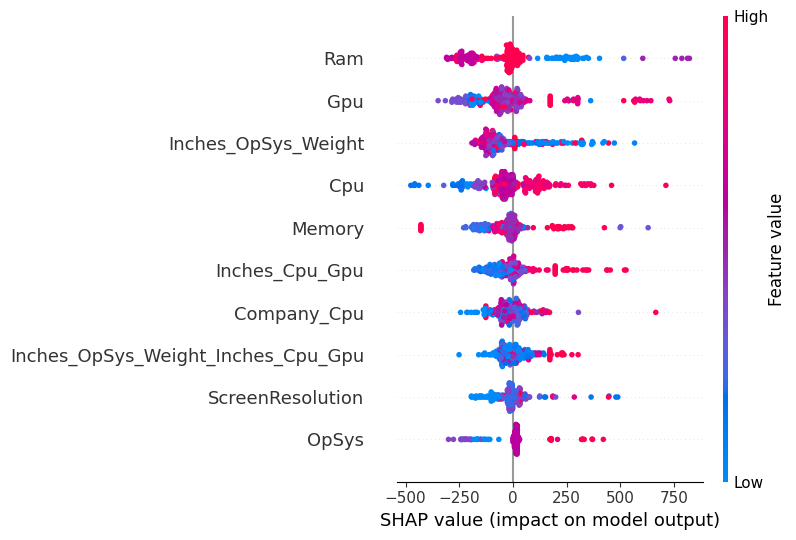

In [20]:
encoded_data = improve_data.copy()

# Select all numeric features (after encoding)
numeric_features = encoded_data.select_dtypes(include=[np.number])

# Calculate SHAP values
explainer = shap.Explainer(best_model, X_train_improve)
shap_values = explainer(X_test_improve)

# Summary plot
shap.summary_plot(shap_values, X_test_improve)

#### Insights
- **High Influence of RAM and GPU**  
   - **RAM** and **GPU** emerge as the most influential features, demonstrating a strong but nuanced impact on price predictions. Their SHAP values highlight that higher or lower values of these features can significantly shift the predicted price, though the effect is not strictly linear. For instance, while increased **RAM** often raises the price, there are cases where it does not contribute proportionally, reflecting diminishing returns in specific configurations. This underscores the complexity of their relationship with the target variable.

- **Effective Contribution of Engineered Features**  
   - Engineered features such as **Inches_Cpu_Gpu** and **Inches_OpSys_Weight** exhibit a steady and meaningful impact on the model's predictions. This validates the success of feature engineering in capturing intricate interactions between hardware and software specifications. These features likely allow the model to generalize better by encapsulating relationships that simpler features fail to express.

- **Secondary Role of ScreenResolution and OpSys**  
   - Features like **ScreenResolution** and **OpSys** play a more limited role in determining price, as their lower SHAP values indicate. However, their contribution is not negligible—they influence predictions in specific cases where display quality or operating system preferences are likely more relevant (e.g., high-resolution screens or premium operating systems).

#### B. permutation importance

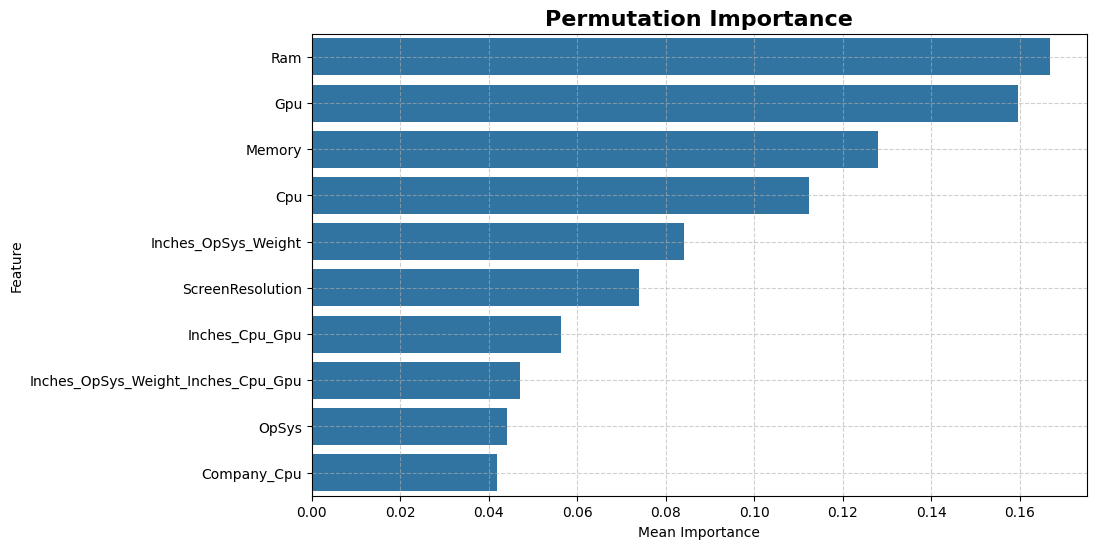

In [21]:
from sklearn.inspection import permutation_importance

# Permutation importance
perm_importance = permutation_importance(best_model, X_test_improve, y_test_improve, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importance
perm_df = pd.DataFrame({
    'Feature': X_test_improve.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_df)
plt.title("Permutation Importance", fontsize=16, fontweight='bold')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Insights
- **Significant Role of RAM and GPU**
   - **RAM** and **GPU** are the most important features according to permutation importance, highlighting their critical role in predicting price. This aligns with industry expectations, as both RAM and GPU strongly influence a laptop's performance and pricing.

- **Impact of Engineered Features**
   - Engineered features such as **Inches_OpSys_Weight** and **Inches_Cpu_Gpu** demonstrate meaningful importance. This validates the feature engineering effort, indicating that combining features has enhanced the model's ability to capture complex relationships.

- **Relatively Low Importance of Some Features**
   - Features like **Company_Cpu** and **OpSys** have comparatively lower importance, suggesting they have limited direct influence on price predictions. However, they might still play an indirect role in capturing variability in the dataset. 


#### C. XGB importance metrics

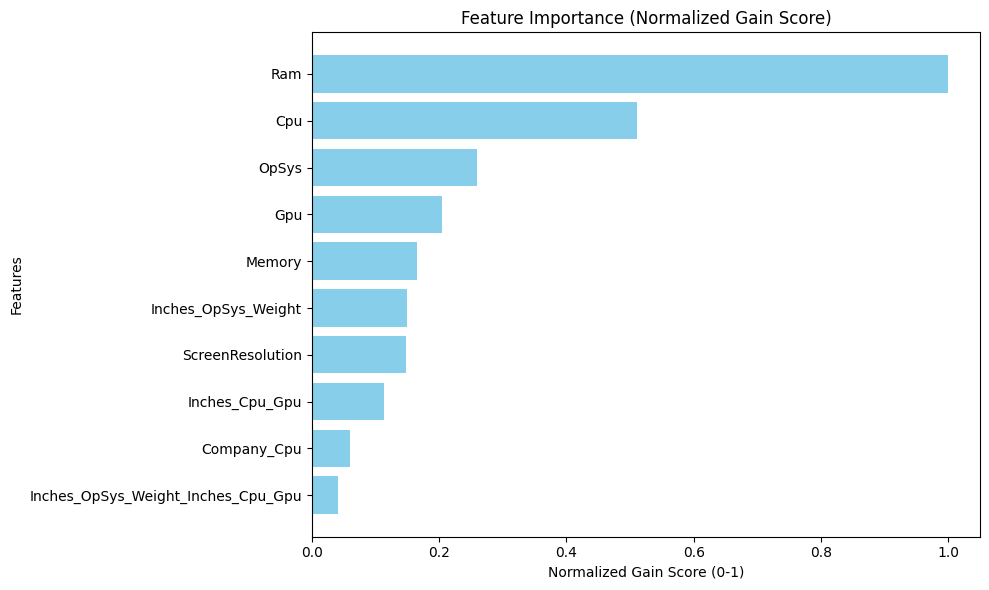

In [31]:
# Extract feature importances from the model
importance = best_model.get_booster().get_score(importance_type='gain')

# Convert to a DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Gain': list(importance.values())
})

# Normalize the gain scores
importance_df['Normalized Gain'] = importance_df['Gain'] / importance_df['Gain'].max()

# Sort by importance
importance_df = importance_df.sort_values(by='Normalized Gain', ascending=False)

# Plot the normalized gain scores
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Normalized Gain'], color='skyblue')
plt.xlabel('Normalized Gain Score (0-1)')
plt.ylabel('Features')
plt.title('Feature Importance (Normalized Gain Score)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


**What does Gain Score mean?**
- **Gain Score** measures the improvement in the objective function (e.g., reduction in prediction error) when a feature is used for splitting.
- A higher gain reflects the feature's stronger contribution to the model's accuracy.

#### Insights

- **Confirming the Dominance of RAM and CPU**  
  - As observed in **Permutation Importance**, **RAM** and **CPU** continue to exhibit dominance in the Gain Score analysis. This reinforces their critical role in determining laptop pricing and highlights their consistent impact on model accuracy.

- **Deepening Understanding of Engineered Features**  
  - Features like **Inches_OpSys_Weight** and **Inches_Cpu_Gpu** again show notable contributions. However, Gain Score further underscores their ability to capture nuanced relationships within the data. This suggests that these engineered features improve the model’s predictive capabilities by representing interactions between raw features.

- **Refining the Role of Visual Features**  
  - While **ScreenResolution** shows a modest Gain Score, its importance in **Permutation Importance** suggests it contributes indirectly to price predictions. Gain Score highlights its role as secondary but still relevant in providing insights into consumer preferences.

### 

## Explain Model Performance

#### Comparing RMSE, MAE, R2, Pearson correlation, EVS. 

In [23]:
# Baseline model metrics
baseline_rmse = 313.30
baseline_mae = 193.69
baseline_r2 = 0.845

print("Comparison of Model Performance Metrics:\n")
print(f"Baseline RMSE: {baseline_rmse:.2f} -> Improved Model RMSE: {rmse_improve:.2f}\n")
print(f"Baseline MAE: {baseline_mae:.2f} -> Improved Model MAE: {mae_improve:.2f}\n")
print(f"Baseline R2 Score: {baseline_r2:.3f} -> Improved Model R2 Score: {r2_improve:.3f}\n")


# Calculate Pearson correlation between actual and predicted
from scipy.stats import pearsonr

# Calculate Pearson correlation for the old model
y_pred_old = y_pred
residuals_old = y_test - y_pred_old
pearson_corr_old, _ = pearsonr(y_test, y_pred_old)

# Calculate Pearson correlation for the new model
residuals_improve = y_test_improve - y_pred_improve
pearson_corr_improve, _ = pearsonr(y_test_improve, y_pred_improve)
print(f"Baseline Pearson Correlation: {pearson_corr_old:.3f} -> Improved Model Pearson Correlation: {pearson_corr_improve:.3f}\n")

# Calculate Explained Variance Score
from sklearn.metrics import explained_variance_score

evs_baseline = explained_variance_score(y_test, y_pred_old)
evs_improve = explained_variance_score(y_test_improve, y_pred_improve)
print(f"Baseline EVS: {evs_baseline:.3f} -> Improved Model EVS: {evs_improve:.3f}")


Comparison of Model Performance Metrics:

Baseline RMSE: 313.30 -> Improved Model RMSE: 252.08

Baseline MAE: 193.69 -> Improved Model MAE: 172.49

Baseline R2 Score: 0.845 -> Improved Model R2 Score: 0.898

Baseline Pearson Correlation: 0.920 -> Improved Model Pearson Correlation: 0.948

Baseline EVS: 0.846 -> Improved Model EVS: 0.899


#### Insights
- **Significant Improvement in Error Metrics**
   - Both **RMSE** (Root Mean Squared Error) and **MAE** (Mean Absolute Error) have shown substantial reductions in the improved model compared to the baseline. This indicates that the improved model is better at minimizing both the average and squared prediction errors, leading to more accurate predictions overall.

- **Enhanced Predictive Power**
   - The **R² score** (from 0.845 to 0.898) and **Pearson Correlation** (from 0.920 to 0.948) improvements highlight that the improved model captures a greater proportion of variance in the data and has stronger alignment between predicted and actual values. These improvements demonstrate the model's enhanced ability to explain and predict the target variable effectively.

- **Better Model Generalization**
   - The **Explained Variance Score (EVS)** increase (from 0.846 to 0.899) reflects the improved model's ability to generalize its predictions, suggesting that the enhanced feature engineering, scaling, and outlier handling methods contributed to a more robust and reliable predictive framework.

<hr>

## Visualization

#### A. Percentage Improvement Plot
This bar chart visually represents the percentage improvement across key model evaluation metrics after applying a series of enhancements, including hyperparameter tuning, feature engineering, and handling outliers. The metrics compared include:

1. **RMSE (Root Mean Squared Error):**<br>
A measure of prediction accuracy, where a higher improvement indicates better alignment between predicted and actual values.
2. **MAE (Mean Absolute Error):**<br>
Captures the average magnitude of prediction errors, with lower values signifying better performance.
3. **R² (R-Squared):**<br>
Reflects the proportion of variance in the target variable explained by the model, with improvements indicating a stronger fit.
4. **Pearson Correlation:**<br>
Measures the linear relationship between predicted and actual values, highlighting the predictive reliability.
5. **EVS (Explained Variance Score):**<br>
Assesses how well the model explains the variability of the data.



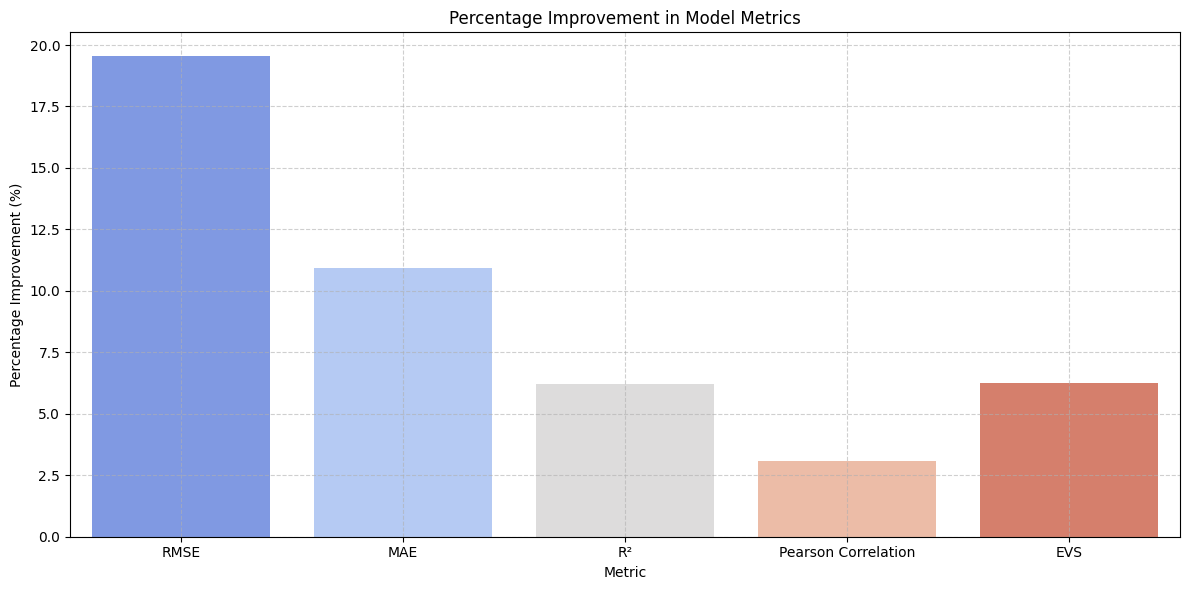

In [24]:
# Calculate percentage improvement
rmse_improvement = ((baseline_rmse - rmse_improve) / baseline_rmse) * 100
mae_improvement = ((baseline_mae - mae_improve) / baseline_mae) * 100
r2_improvement = ((r2_improve - baseline_r2) / baseline_r2) * 100
pearson_improvement = ((pearson_corr_improve - pearson_corr_old) / pearson_corr_old) * 100
evs_improvement = ((evs_improve - evs_baseline) / evs_baseline) * 100

# Define metrics and their improvements
metrics = ['RMSE', 'MAE', 'R²', 'Pearson Correlation', 'EVS']
improvements = [rmse_improvement, mae_improvement, r2_improvement, pearson_improvement, evs_improvement]

# Plot percentage improvement
plt.figure(figsize=(12, 6))
sns.barplot(x=metrics, y=improvements, palette='coolwarm')
plt.title("Percentage Improvement in Model Metrics")
plt.xlabel("Metric")
plt.ylabel("Percentage Improvement (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Insights
- **Significant RMSE Improvement**:
   - The largest improvement is observed in the **RMSE** (Root Mean Squared Error), with nearly 20% improvement. This indicates that the improved model makes smaller errors on average, particularly on larger deviations, suggesting better handling of extreme values or outliers.

- **Moderate MAE Improvement**:
   - The **MAE** (Mean Absolute Error) shows a moderate improvement of around 12%, indicating the model's enhanced ability to reduce average absolute prediction errors across the dataset.

- **Consistency in Generalization Metrics**:
   - Improvements in metrics like **R²**, **Pearson Correlation**, and **EVS** (Explained Variance Score) are smaller but consistent. This suggests that the new model achieves slightly better alignment between predicted and actual values, while also explaining more variance in the target variable.

These improvements collectively highlight the enhanced accuracy and robustness of the improved model compared to the baseline. 

<hr>

#### B. Baseline vs Improved Scatter Plots (Predicted vs. Actual Values)
The visualization presented here compares the performance of two models: the old and improved models. Each scatter plot showcases the relationship between the actual and predicted prices generated by the respective models. The red dashed line, labeled "Perfect Fit," represents the ideal scenario where the expected values match the actual values perfectly. This side-by-side comparison highlights the predictive accuracy and any potential deviations from the perfect fit for each model.

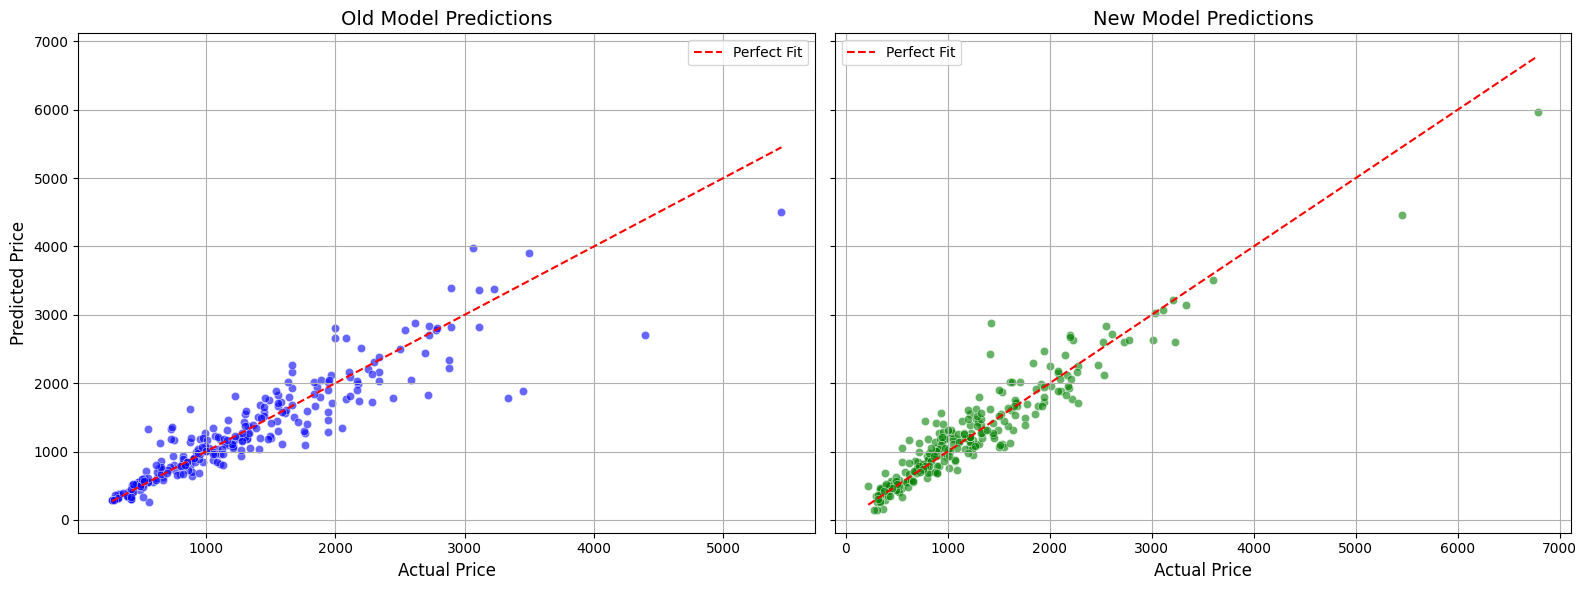

In [25]:
# Create side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for the old model
sns.scatterplot(x=y_test, y=y_pred_old, alpha=0.6, ax=axes[0], color="blue")
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
axes[0].set_title("Old Model Predictions", fontsize=14)
axes[0].set_xlabel("Actual Price", fontsize=12)
axes[0].set_ylabel("Predicted Price", fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Plot for the new model
sns.scatterplot(x=y_test_improve, y=y_pred_improve, alpha=0.6, ax=axes[1], color="green")
axes[1].plot([y_test_improve.min(), y_test_improve.max()], [y_test_improve.min(), y_test_improve.max()], 'r--', label='Perfect Fit')
axes[1].set_title("New Model Predictions", fontsize=14)
axes[1].set_xlabel("Actual Price", fontsize=12)
axes[1].set_ylabel("Predicted Price", fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### Insights
- **Improved Alignment with Perfect Fit**:
   - The scatterplot for the new model (right) shows predictions much closer to the red dashed line (representing the perfect fit) compared to the old model (left). This indicates that the new model has improved predictive accuracy and better aligns with actual prices.

- **Reduced Overestimation and Underestimation**:
   - In the old model, there are noticeable deviations where the model overestimates or underestimates prices, particularly for higher price ranges. In the new model, these deviations are significantly reduced, highlighting better handling of both high and low price ranges.

- **Better Handling of Outliers**:
   - The new model demonstrates improved performance on outliers, as evident from the tighter clustering of predictions for extreme price values. This suggests that the new model incorporates techniques that address outlier effects more effectively, improving its generalization capability.

<hr>

#### C. Baseline vs Improved Residual distributions plot
Residual Distribution Comparison (Old vs. New Model)
The residual distribution plots are provided to compare the errors of the old and new models. Residuals represent the difference between actual and predicted values. A tighter distribution around zero indicates better model performance. These plots help evaluate whether the new model has improved error distribution and minimized outliers compared to the baseline.

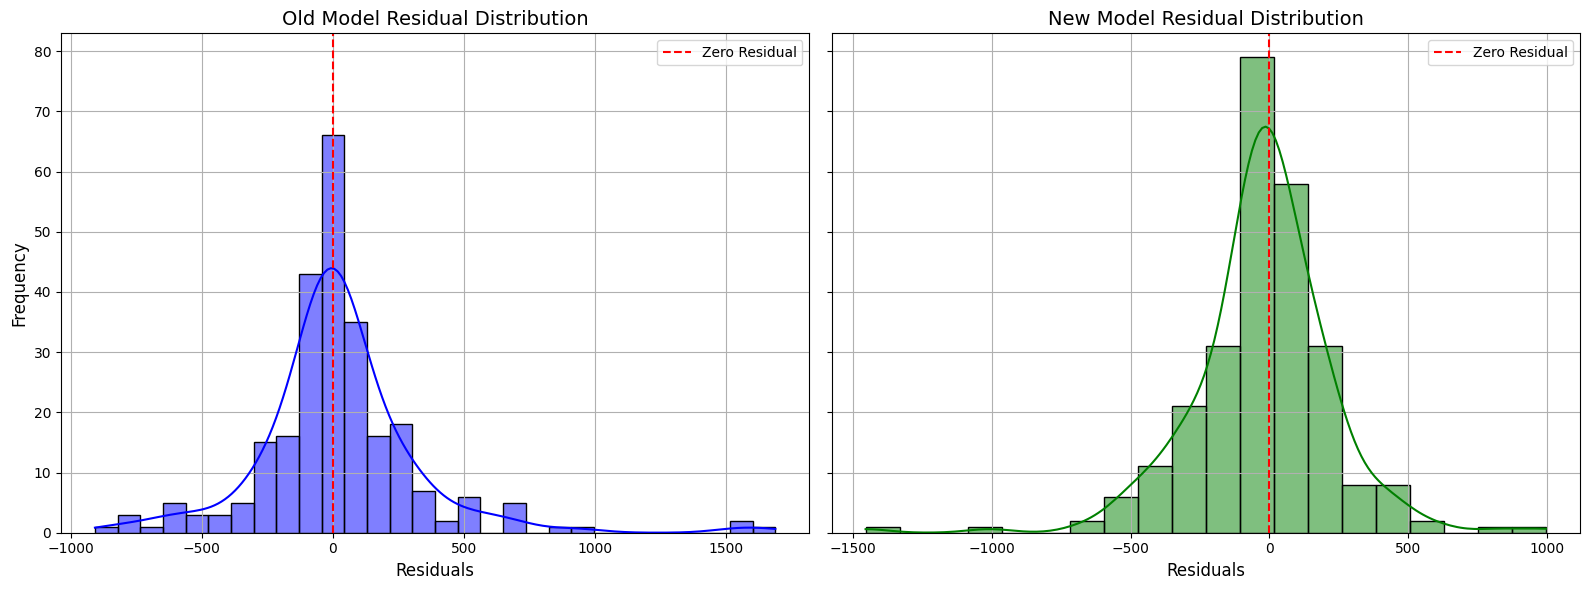

In [26]:
# Create side-by-side plots for residual distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot residuals for the old model
sns.histplot(residuals_old, kde=True, bins=30, color='blue', ax=axes[0])
axes[0].axvline(x=0, color='red', linestyle='--', label='Zero Residual')
axes[0].set_title("Old Model Residual Distribution", fontsize=14)
axes[0].set_xlabel("Residuals", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Plot residuals for the new model
sns.histplot(residuals_improve, kde=True, bins=20, color='green', ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='--', label='Zero Residual')
axes[1].set_title("New Model Residual Distribution", fontsize=14)
axes[1].set_xlabel("Residuals", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### Insights
- **Reduced Residual Spread in the New Model**:
   - The residuals in the new model (right) are more tightly clustered around zero compared to the old model (left). This indicates improved accuracy and reduced prediction errors, particularly for the majority of the data points.

- **Symmetry and Reduced Bias**:
   - The new model demonstrates a more even distribution of residuals on both sides of zero, suggesting it avoids consistently overestimating or underestimating prices. This balanced residual distribution highlights an improvement in how the model handles predictions across different price ranges, reducing systematic errors present in the old model.

- **Better Handling of Extreme Residuals**:
   - The new model significantly reduces the frequency and magnitude of extreme residuals (both positive and negative) compared to the old model. This improvement reflects the new model's enhanced ability to generalize across different data points, including outliers and edge cases.

<hr>

#### D. Baseline vs Improved permutation importance Plot
The side-by-side permutation importance plots show the contribution of each feature to the model's predictions in both the old and improved models. By analyzing the importance scores, we can identify how feature relevance has shifted due to feature engineering and improved model tuning. This visualization aids in understanding which features drive the predictions and how their importance evolved between the models.

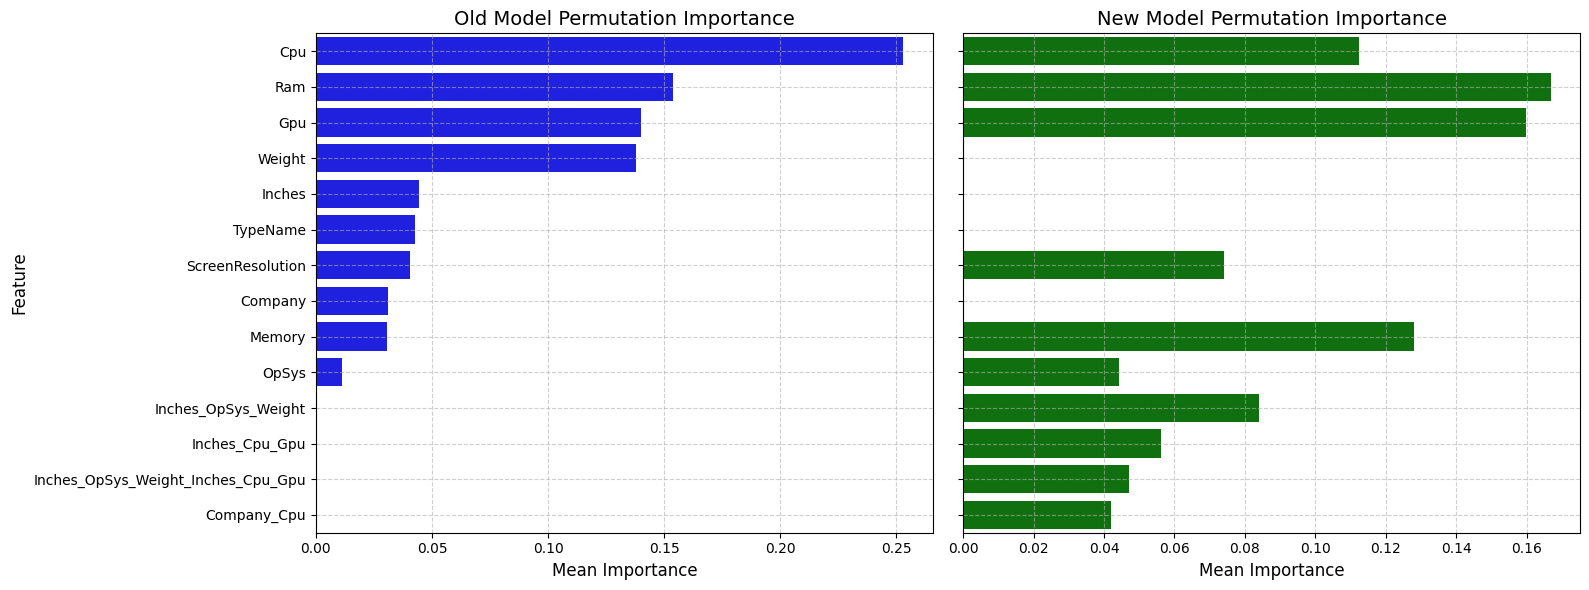

In [27]:
# Permutation importance
perm_importance_old = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importance
perm_df_old = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance_old.importances_mean
}).sort_values(by='Importance', ascending=False)


# Create permutation importance plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Old model
sns.barplot(x=perm_df_old['Importance'], y=perm_df_old['Feature'], ax=axes[0], color='blue')
axes[0].set_title("Old Model Permutation Importance", fontsize=14)
axes[0].set_xlabel("Mean Importance", fontsize=12)
axes[0].set_ylabel("Feature", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Improved model
sns.barplot(x=perm_df['Importance'], y=perm_df['Feature'], ax=axes[1], color='green')
axes[1].set_title("New Model Permutation Importance", fontsize=14)
axes[1].set_xlabel("Mean Importance", fontsize=12)
axes[1].set_ylabel("Feature", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


#### Insights  

- **Enhanced Reliance on Diverse Features**:  
   - The new model effectively utilizes a wider range of features, spreading importance more evenly across raw and engineered variables. Unlike the old model, which heavily depended on **CPU**, **RAM**, and **GPU**, the new model demonstrates a deeper understanding of the dataset by incorporating a broader spectrum of predictors.

- **Strategic Impact of Engineered Features**:  
   - Engineered features, such as **Inches_OpSys_Weight** and **Inches_Cpu_Gpu**, now play a substantial role in the new model's predictions. This validates the feature engineering efforts, as these features successfully captured non-linear relationships and complex interactions that were not apparent in the raw data.

<hr>

#### E. Baseline vs Improved Correlation Heatmaps
The side-by-side correlation heatmaps illustrate the relationships between features in the baseline and improved datasets. These visualizations highlight how feature engineering and preprocessing have impacted the dataset’s structure.

The baseline heatmap represents the initial dataset, where simple categorical encoding was applied, and raw features were retained. The improved heatmap reflects the dataset after feature engineering and optimization, showcasing the refined relationships and the introduction of engineered features. These comparisons aim to demonstrate how preprocessing has enhanced feature interdependencies and strengthened the dataset's predictive power.

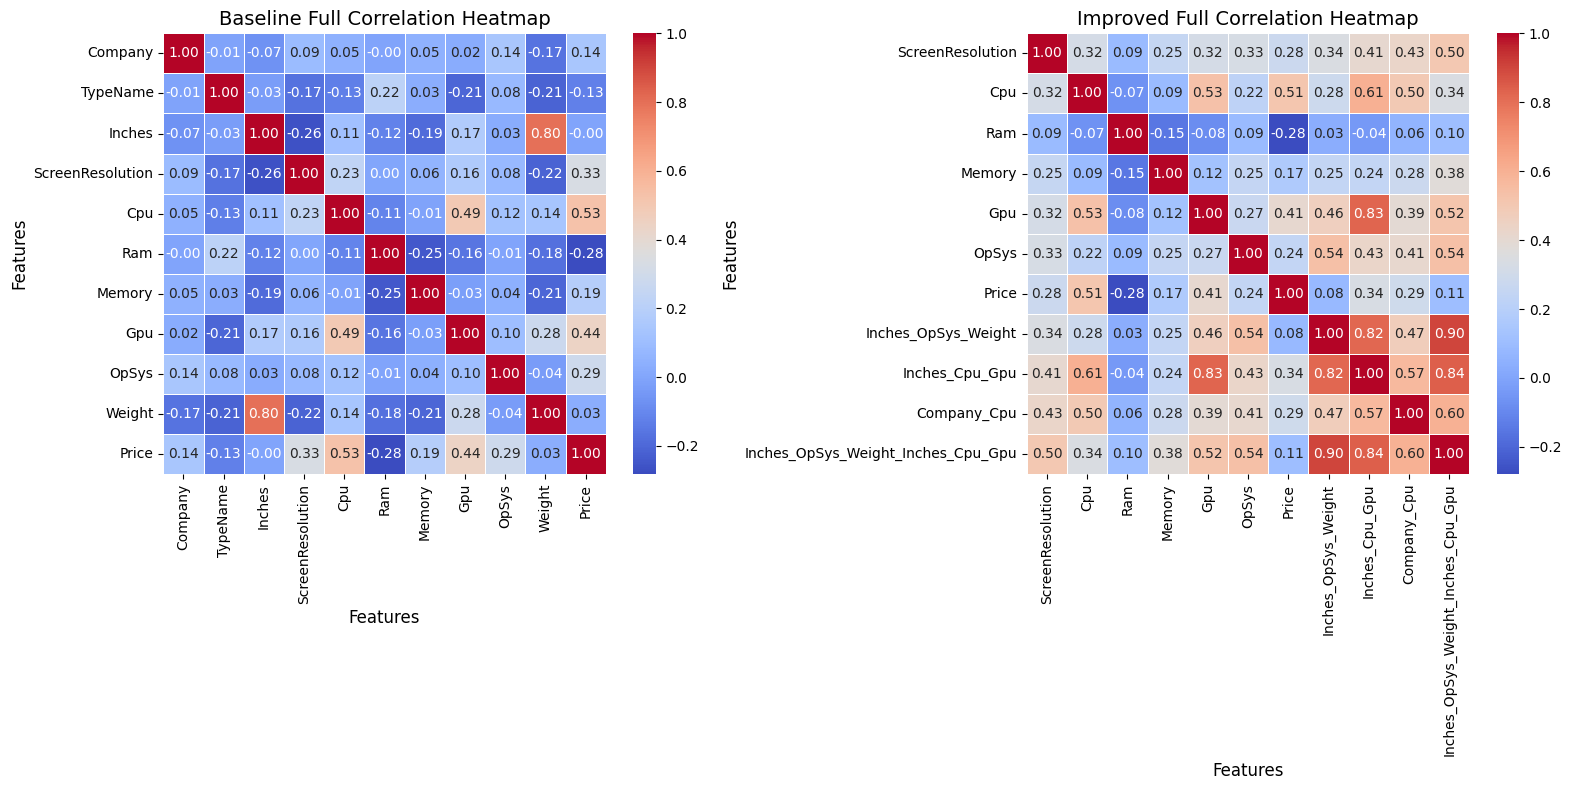

In [28]:
from sklearn.preprocessing import LabelEncoder

# Baseline preprocessing correlation metric
categorical_features = ['Company', 'TypeName', 'OpSys' , 'Gpu', 'Memory', 'Ram', 'Cpu', 'ScreenResolution', 'Inches', 'Weight']
encoder = LabelEncoder()
encoded_data = copy_data.copy()

for feature in categorical_features:
    encoded_data[feature] = encoder.fit_transform(encoded_data[feature])

# Remove the 'ID' column
Baseline_encoded_data = encoded_data.drop(columns=['ID'])

# Select all Baseline numeric features (after encoding)
numeric_features = Baseline_encoded_data.select_dtypes(include=[np.number])

# Calculate full correlation matrices
baseline_corr_full = numeric_features.corr()
improved_corr_full = improve_data.corr()

# Create side-by-side heatmaps for full correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Baseline full correlation heatmap
sns.heatmap(
    baseline_corr_full, annot=True, cmap='coolwarm', fmt=".2f",
    linewidths=0.5, ax=axes[0]
)
axes[0].set_title("Baseline Full Correlation Heatmap", fontsize=14)
axes[0].set_xlabel("Features", fontsize=12)
axes[0].set_ylabel("Features", fontsize=12)

# Improved full correlation heatmap
sns.heatmap(
    improved_corr_full, annot=True, cmap='coolwarm', fmt=".2f",
    linewidths=0.5, ax=axes[1]
)
axes[1].set_title("Improved Full Correlation Heatmap", fontsize=14)
axes[1].set_xlabel("Features", fontsize=12)
axes[1].set_ylabel("Features", fontsize=12)

# Adjust layout and show
plt.tight_layout()
plt.show()


#### insights
- **Increased Relationships in Engineered Features**:
   - In the improved heatmap, engineered features such as **Inches_OpSys_Weight**, **Inches_Cpu_Gpu**, and **Company_Cpu** exhibit moderate-to-high correlations with the target variable (`Price`) and with other features.
   - This indicates that feature engineering has successfully captured additional relationships that were not apparent in the baseline dataset.

- **Elimination of Redundant Features**:
   - In the improved model, features like **Inches** and **Weight** were removed entirely, simplifying the dataset and reducing potential noise. The introduction of engineered features such as **Inches_OpSys_Weight** effectively replaced these removed features, capturing their combined relationships with the target variable. This demonstrates a focused effort to streamline the feature set while retaining relevant information.
   
- **Increased Positive Correlations Among Features**:
   - The improved heatmap shows a higher degree of positive correlations not only between individual features and the target (`Price`) but also among the features themselves.
   - This suggests that the improved dataset better represents the linear and complex relationships, enabling the model to make more nuanced and accurate predictions.


#### Additional Note:
These heatmaps visually reinforce the effectiveness of feature engineering and preprocessing in improving the dataset's structure, which likely contributed to the enhanced predictive performance of the model.

<hr>

## Drawing Conclusions About the Data & Creative Applications

### A. Analyze what the improved model reveals about the data:
- **Feature Significance**
    - Based on **SHAP values**, **Feature Importance**, or **XGBoost Gain scores**, features like `RAM`, `CPU`, and `GPU` appear to be the most influential.
    These metrics consistently highlight their substantial impact on model predictions, indicating that these features play a critical role in determining laptop prices.
    Their significance aligns with their direct influence on a laptop's performance, making them key differentiators for both manufacturers and consumers.

- **Biases or Trends**
    - **Hardware vs. Software Bias**
    The dataset strongly emphasizes hardware features (CPU, GPU, RAM) over software-related features like OpSys, indicating a potential bias where consumer behavior or dataset composition undervalues the role of software in pricing decisions.

    - **Positive Correlations**
    The strong positive correlations observed between features like CPU, GPU, and ScreenResolution and price represent clear trends in the dataset. These correlations highlight consistent patterns where higher-performing hardware and better display quality are strongly associated with increased laptop prices. This trend reflects consumer priorities, emphasizing performance and visual quality as key drivers of value in the market.

- **Data Insights**

    - **Surprising Role of RAM**
    While **RAM** is expected to have a strong positive correlation with price due to its critical role in performance, the results were mixed.
    This divergence may reflect market trends where increasing RAM beyond a certain threshold provides diminishing perceived value, despite its importance in the specifications.
    This finding runs counter to the typical assumption that more RAM consistently correlates to higher prices due to its impact on performance.

    - **Unexpectedly Modest Role of OpSys**
        The operating system (**OpSys**) was expected to have a significant impact on price due to its association with premium branding and market segmentation (e.g., macOS for Apple devices, Windows Pro for businesses). However, the weak correlation and limited impact on the model suggest that the dataset is either under-representing its value or that consumers and manufacturers do not prioritize the operating system as a key pricing factor.
        This finding is interestingly, despite the brand weight carried by operating systems like macOS (for Apple laptops), the results suggest that this feature is treated as secondary compared to hardware specifications like CPU and GPU.

    - **Unexpected impact of engineered features**
        Engineered features such as **Inches_OpSys_Weight** and **Inches_Cpu_Gpu** emerged as influential despite their raw components (e.g., **Inches** and **Weight**) having weaker correlations with price.
        This discrepancy suggests that the interaction of multiple dimensions—combining hardware and software features—captures hidden relationships that raw features alone cannot represent. While this demonstrates the power of feature engineering, it is surprising that these derived features outperform some standalone features traditionally associated with price, such as **RAM** and **OpSys**.
<hr>

### B. Findings Explanation
In analyzing the data and improving the predictive model, we uncovered several key insights about the factors influencing laptop prices. Here's a breakdown of the findings in simple, relatable terms:

- **What Drives Laptop Prices the Most?**  
   - Think about what you value when buying a laptop. Our findings show that it's typically the **CPU**, **GPU**, and **RAM**. These components stood out as the most significant drivers of price, which makes sense because they directly affect the laptop's performance.  
   - For example, a high-end graphics card or a powerful processor adds a premium to the price tag, as these features cater to gamers and professionals needing robust performance.

- **The Surprising Role of RAM!**  
    - We often associate more **RAM** with a higher price. While this holds to an extent, we found diminishing returns for very high RAM capacities.  
    - This means that after a certain point (e.g., 16GB or 32GB), adding more RAM doesn't increase the price as much as you'd expect. It seems the market doesn’t value extra RAM as much as other components once the baseline needs are met.

- **Why Doesn't the Operating System Matter Much?**  
    - You might assume that premium operating systems like **macOS** or **Windows Pro** would play a big role in pricing. However, our model found that the operating system has a surprisingly small impact.  
    This suggests that consumers are more focused on hardware performance than the software running on their laptops, or that the dataset itself underrepresents the influence of operating systems.

#### **Takeaway for Consumers and Businesses**  
For consumers, understanding these insights can help make smarter purchasing decisions by focusing on features that truly matter for performance and value. For manufacturers, this analysis sheds light on which features customers prioritize, enabling better product design and pricing strategies.
<hr>

### C. **Potential Applications**
**1. Marketing Campaigns for Laptop Retailers**
- Retailers can leverage insights about the importance of **CPU**, **GPU**, and **RAM** to tailor their marketing strategies. For instance, they can:
    - Highlight laptops with high-performance specifications in advertisements targeting gamers or professionals.
    - Emphasize budget-friendly options with moderate specifications for students or casual users.
- **Impact:** This targeted approach can optimize ad spend and increase conversion rates by appealing to specific customer segments.

**2. Price Prediction Tool for Consumers**
- Build a **Laptop Price Estimation Tool** where users input desired specifications (e.g., CPU, RAM, GPU, screen resolution) to get a predicted price range.  
- **Impact**  
    - Helps consumers plan their purchases more effectively by providing realistic expectations based on market trends.
    - Helps consumers understand where to buy laptops by checking whether certain places are pricing their laptops too low or too high, which could be suspicious.
- **Inspiration:** 
Platforms like [Zap](https://www.zap.co.il/) inspired creating tools that help users compare pricing and find optimal value.  

**3. Inventory Optimization tool for Retailers**
- Use the model to identify price points and feature combinations in high demand. Retailers can stock more laptops within these specifications to maximize sales.  
- **Impact:**  
    - Minimizes unsold inventory of expensive, under-demand laptops (e.g., those with excessive RAM or niche features).  
    - Aligns inventory with market trends, reducing waste and improving profits.
- **Inspiration:**  
   This idea was inspired by the article **"A Definitive Guide to Optimizing Inventory Management in Retail"** by Samsung Insights. The article discusses how technological advancements and changing consumer behaviors enable retailers to manage inventory more accurately, enhancing productivity and profitability.  
   "Changes in the way consumers shop have raised customer expectations, but they also allow retailers to finally ensure accurate inventory,  ...  And they can do so cost-effectively, boosting productivity, performance and the bottom line."*  
   ([Read the article here](https://insights.samsung.com/2024/06/25/a-definitive-guide-to-optimizing-inventory-management-in-retail-2/?utm_source=chatgpt.com))  

**4. Feature Benchmarking for Manufacturers**
- Laptop manufacturers can analyze the diminishing returns for certain features like **RAM** and focus on cost-effective hardware combinations that balance performance and price.  
- **Impact:**  
    - Enables manufacturers to design laptops that cater to consumer preferences while minimizing unnecessary costs.
    - Helps identify opportunities to differentiate products based on undervalued features (e.g., **operating system upgrades**).

**5. Customer Recommendations tool**
- **Inspiration:** Platforms like [שם זה הזול יותר](https://yossidisk.github.io/Shamze/home.html) guided the idea of using data-driven insights to recommend products tailored to customer preferences and budgets.  
- Create a recommendation system for e-commerce platforms to suggest laptops based on user preferences and budget constraints.  
- **Impact:**  
    - Improves customer satisfaction by simplifying the decision-making process.
    - Increases platform engagement and sales conversion rates.